In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import glob
import json
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [2]:
val = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/valid/images/*.jpg')
test = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/test/images/*.jpg')
val_files = np.unique(np.array([x.split('/')[-1][:3] for x in val]))
test_files = np.unique(np.array([x.split('/')[-1][:3] for x in test]))

In [3]:
cell_files = sorted([f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/cell/{idx}.jpg' for idx in test_files])
tissue_files = sorted([f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/{idx}.jpg' for idx in test_files])
cell_csvs = sorted([f'/workspace/jay/DDP/Ocelot/ocelot2023/annotations/train/cell/{idx}.csv' for idx in test_files])
tissue_masks = sorted([f'/workspace/jay/DDP/Ocelot/ocelot2023/annotations/train/tissue/{idx}.png' for idx in test_files])
with open('/workspace/jay/DDP/Ocelot/ocelot2023/metadata.json') as f:
    jsonn = json.load(f)

In [4]:
pred_json = {
    "type": "Multiple points",
    "num_images": len(cell_files),
    "points": [],
    "version": {
        "major": 1,
        "minor": 0,
    }
}

In [5]:
for j,file in enumerate(tqdm(cell_files)):
    idx = int(file.split('/')[-1][:-4]) -1 
    name = file.split('/')[-1][:-4]
    #img = np.array(Image.open(file))
    try:
        df = pd.read_csv(cell_csvs[j],header=None)
        annot = np.array(Image.open(tissue_masks[j]))
        tissue_mask = np.zeros((3,annot.shape[0],annot.shape[1]))
        tissue_mask[0][np.where(annot==1)] = 1
        tissue_mask[1][np.where(annot==2)] = 1
        tissue_mask[2][np.where(annot==255)] = 1
        tissue_mask = np.moveaxis(tissue_mask,0,-1)

        yc = int(jsonn['sample_pairs'][name]['patch_x_offset']*1024)
        xc = int(jsonn['sample_pairs'][name]['patch_y_offset']*1024)
        tissue_crop = tissue_mask[xc-128:xc+128,yc-128:yc+128,:]
        tissue_crop = cv2.resize(tissue_crop, dsize=(1024,1024), interpolation = cv2.INTER_NEAREST)

        for i in range(len(df)):
            x,y = max(0,df.loc[i][0]+random.randint(-5,5)) , max(0,df.loc[i][1]+random.randint(-5,5))
            prob = 1
            clas = np.argmax(tissue_crop[y,x,:])
            if clas==2:
                pass
            else:
                point = {
                        "name": f"image_{idx}",
                        "point": [int(x), int(y), int(clas)+1],
                        "probability": 1.0,  # dummy value, since it is a GT, not a prediction
                        }
                pred_json["points"].append(point)
    except:
        pass
                                

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.40it/s]


In [6]:
with open("/workspace/jay/DDP/Ocelot/ocelot23algo/evaluation/tissue_test_test.json", "w") as g:
    json.dump(pred_json, g)
    print("JSON file saved")

JSON file saved


In [8]:
# j=3
# idx = int(cell_files[j].split('/')[-1][:-4]) -1 
# name = cell_files[j].split('/')[-1][:-4]
# #img = np.array(Image.open(file))
# df = pd.read_csv(cell_csvs[j],header=None)
# annot = np.array(Image.open(tissue_masks[j]))
# tissue = np.array(Image.open(tissue_files[j]))
# tissue_mask = np.zeros((3,annot.shape[0],annot.shape[1]))
# tissue_mask[0][np.where(annot==1)] = 1
# tissue_mask[1][np.where(annot==2)] = 1
# tissue_mask[2][np.where(annot==255)] = 1
# tissue_mask = np.moveaxis(tissue_mask,0,-1)

# xc = int(jsonn['sample_pairs'][name]['patch_x_offset']*1024)
# yc = int(jsonn['sample_pairs'][name]['patch_y_offset']*1024)
# tissue_crop = tissue_mask[xc-128:xc+128,yc-128:yc+128,:]
# tissue_crop = cv2.resize(tissue_crop, dsize=(1024,1024), interpolation = cv2.INTER_NEAREST)

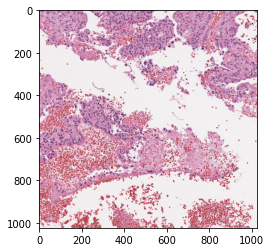

In [9]:
plt.imshow(tissue)

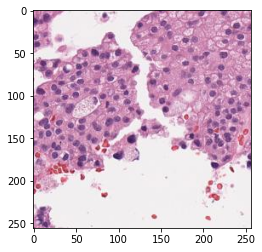

In [13]:
plt.imshow(tissue[yc-128:yc+128,xc-128:xc+128,:])

In [14]:
df

,0,1,2
0,43,932,2
1,228,548,2
2,771,226,2
3,818,204,2
4,326,213,2
...,...,...,...
172,710,640,2
173,918,609,2
174,951,520,2
175,920,502,2
